<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/Pollardstown_S_W_svm_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip
!unzip -q "/content/drive/MyDrive/Pollardstown.zip" -d "/content/dataset"


In [3]:
!ls /content/dataset/Pollardstown/

'habitat info.docx'	     Pollardstown_clappied.shx
 Pollardstown_clappied.cpg   pollardstown_ortho.tif
 Pollardstown_clappied.dbf   Pollardstown_Summer_NDVI.tif
 Pollardstown_clappied.prj   Pollardstown_Winter_NDVI.tif
 Pollardstown_clappied.qmd   Pollardstown_Winter_RGB.tif
 Pollardstown_clappied.shp


In [1]:
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from rasterio.vrt import WarpedVRT
from shapely.geometry import Point
from scipy.ndimage import median_filter

In [2]:
S_RGB_PATH = '/content/dataset/Pollardstown/pollardstown_ortho.tif'
S_NDVI_PATH = '/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif'
W_NDVI_PATH = '/content/dataset/Pollardstown/Pollardstown_Winter_NDVI.tif'
W_RGB_PATH = '/content/dataset/Pollardstown/Pollardstown_Winter_RGB.tif'
SHP_PATH = '/content/dataset/Pollardstown/Pollardstown_clappied.shp'

LABEL_COL = 'Id'
NAME_COL = 'PRIMARY_FO'

In [3]:
TARGET_DENSITY = 0.2
MIN_SAMPLES = 100
MAX_SAMPLES = 4000
MIN_AREA_THRESHOLD = 25

In [4]:
with rasterio.open(S_RGB_PATH) as r1, rasterio.open(W_RGB_PATH) as r2:
    print(f"Summer size: {r1.shape}")
    print(f"Winter size: {r2.shape}")
    if r1.shape == r2.shape:
        print("Shapes match! You might not need Step 1.")

Summer size: (40000, 40000)
Winter size: (20562, 28876)


In [5]:
def align_raster_safe(src_path, master_meta, out_name):
    print(f"Aligning {src_path} in chunks...")
    with rasterio.open(src_path) as src:
        out_meta = master_meta.copy()
        out_meta.update(count=src.count, dtype='float32', compress='lzw') # Added compression

        with WarpedVRT(src, crs=master_meta['crs'], transform=master_meta['transform'],
                        width=master_meta['width'], height=master_meta['height']) as vrt:
            with rasterio.open(out_name, 'w', **out_meta) as dst:
                for _, window in dst.block_windows():
                    # Only read the specific window needed
                    data = vrt.read(window=window).astype('float32')
                    dst.write(data, window=window)
    return out_name

# Initialize Master Grid from Summer RGB
with rasterio.open(S_RGB_PATH) as s_rgb_src:
    master_meta = s_rgb_src.meta.copy()

# Run alignments (one by one to save RAM)
s_ndvi_f = align_raster_safe(S_NDVI_PATH, master_meta, 's_ndvi_f.tif')
w_rgb_f = align_raster_safe(W_RGB_PATH, master_meta, 'w_rgb_f.tif')
w_ndvi_f = align_raster_safe(W_NDVI_PATH, master_meta, 'w_ndvi_f.tif')

Aligning /content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif in chunks...
Aligning /content/dataset/Pollardstown/Pollardstown_Winter_RGB.tif in chunks...
Aligning /content/dataset/Pollardstown/Pollardstown_Winter_NDVI.tif in chunks...


In [6]:
gdf = gpd.read_file(SHP_PATH).to_crs(master_meta['crs'])
fossitt_merger = {
    'WN6': 'Woodland_Scrub', 'WL2': 'Woodland_Scrub', 'WS1/WL2': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub', 'GS4/WS1': 'Woodland_Scrub', 'Scrub_Woodland': 'Woodland_Scrub',
    'GA1': 'Grassland_Improved', 'GS4': 'Grassland_Wet',
    'PF1': 'Wetland_Peatland', 'FS1': 'Wetland_Peatland', 'FS1/FS2': 'Wetland_Peatland',
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland', 'GS4/FS2': 'Wetland_Peatland'
}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [7]:
# @title
X_list, y_list = [], []
print("Sampling points from large rasters...")
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(s_ndvi_f) as sn, \
     rasterio.open(w_rgb_f) as wr, rasterio.open(w_ndvi_f) as wn:

    for idx, row in gdf.iterrows():
        poly_area = row.geometry.area
        target_n = max(MIN_SAMPLES, min(int(poly_area * TARGET_DENSITY), MAX_SAMPLES))

        # Generate points
        points = []
        b = row.geometry.bounds
        while len(points) < target_n:
            xs, ys = np.random.uniform(b[0], b[2], target_n), np.random.uniform(b[1], b[3], target_n)
            for x, y in zip(xs, ys):
                if row.geometry.contains(Point(x, y)): points.append((x, y))
            if len(points) > target_n * 5: break

        # Sample values
        for val in zip(sr.sample(points), sn.sample(points), wr.sample(points), wn.sample(points)):
            sr_v, sn_v, wr_v, wn_v = [v.flatten() for v in val]
            if not np.any(sr_v == 0) and not np.any(wr_v == 0):
                X_list.append(np.concatenate([sr_v, sn_v, wr_v, wn_v, [np.std(sr_v)]]))
                y_list.append(row['merged_name'])

Sampling points from large rasters...


KeyboardInterrupt: 

In [7]:
X_list, y_list = [], []
print("Starting High-Speed Point Sampling...")

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(s_ndvi_f) as sn, \
     rasterio.open(w_rgb_f) as wr, rasterio.open(w_ndvi_f) as wn:

    for idx, row in gdf.iterrows():
        # Get bounds of the polygon
        minx, miny, maxx, maxy = row.geometry.bounds

        # Determine number of samples
        poly_area = row.geometry.area
        target_n = max(MIN_SAMPLES, min(int(poly_area * 0.05), MAX_SAMPLES))

        points_coords = []
        attempts = 0

        # Faster point generation: generate in small batches
        while len(points_coords) < target_n and attempts < 10:
            # Generate random points within the bounding box
            xs = np.random.uniform(minx, maxx, target_n * 2)
            ys = np.random.uniform(miny, maxy, target_n * 2)

            # Use a list comprehension for faster containment check
            valid_points = [
                (x, y) for x, y in zip(xs, ys)
                if row.geometry.contains(Point(x, y))
            ]
            points_coords.extend(valid_points[:target_n - len(points_coords)])
            attempts += 1

        if not points_coords:
            continue

        # Extract values using .sample() - this is memory efficient
        # zip() combines the generators into one loop
        s_rgb_samples = list(sr.sample(points_coords))
        s_ndvi_samples = list(sn.sample(points_coords))
        w_rgb_samples = list(wr.sample(points_coords))
        w_ndvi_samples = list(wn.sample(points_coords))

        for sr_v, sn_v, wr_v, wn_v in zip(s_rgb_samples, s_ndvi_samples, w_rgb_samples, w_ndvi_samples):
            # Flatten because sample returns arrays
            sr_v, sn_v, wr_v, wn_v = sr_v.flatten(), sn_v.flatten(), wr_v.flatten(), wn_v.flatten()

            # Only keep pixels with data
            if not np.any(sr_v == 0) and not np.any(wr_v == 0):
                texture = np.std(sr_v)
                X_list.append(np.concatenate([sr_v, sn_v, wr_v, wn_v, [texture]]))
                y_list.append(row['merged_name'])

        if idx % 100 == 0:
            print(f"Polygon {idx}/{len(gdf)} processed. Samples so far: {len(X_list)}")

X, y = np.array(X_list), np.array(y_list)
print(f"Total samples collected: {len(X)}")

Starting High-Speed Point Sampling...
Total samples collected: 11186


In [8]:
print("Training Model...")
X, y = np.array(X_list), np.array(y_list)
unique_names = np.unique(y).tolist()
y_int = np.array([unique_names.index(name) for name in y])

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, stratify=y_int)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

clf = SVC(kernel='rbf', C=10, class_weight='balanced')
clf.fit(X_train_scaled, y_train)
print(classification_report(y_test, clf.predict(scaler.transform(X_test)), target_names=unique_names))

Training Model...
                  precision    recall  f1-score   support

   Grassland_Wet       0.49      0.68      0.57       435
Wetland_Peatland       0.94      0.78      0.85      1585
  Woodland_Scrub       0.44      0.66      0.53       218

        accuracy                           0.75      2238
       macro avg       0.62      0.71      0.65      2238
    weighted avg       0.81      0.75      0.77      2238



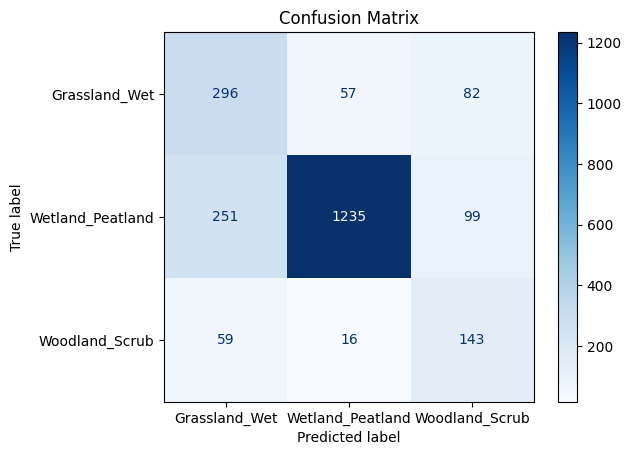

In [9]:
y_pred = clf.predict(scaler.transform(X_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=unique_names, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

File: /content/dataset/Pollardstown/Pollardstown_Winter_RGB.tif
Number of bands: 3
Width/Height: 28876 x 20562
Band 1: red (uint8)
Band 2: green (uint8)
Band 3: blue (uint8)
